<a href="https://colab.research.google.com/github/Buyan-Kirill/practice-VTM-sem-8/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from logging import exception
import numpy as np
import time
import random
import scipy
import matplotlib.pyplot as plt

In [31]:
def givens_rotation(a, b):
    if b == 0:
        c = 1
        s = 0
    else:
        if abs(b) > abs(a):
            tau = -a / b
            s = 1 / np.sqrt(1 + tau ** 2)
            c = s * tau
        else:
            tau = -b / a
            c = 1 / np.sqrt(1 + tau ** 2)
            s = c * tau
    return c, s

def qr_pivoting(A, error = 0, rank = 0):
    n, m = A.shape  # n columns, m rows
    if m < n:
        raise exception("Invalid size of matrix: m < n")
    piv = [i for i in range(n)]
    piv = sorted(piv, key=lambda i: np.linalg.norm(A[i]), reverse=True)
    A = A[piv]
    err = 0
    for j in range(n):
        v = A[j]
        err += np.linalg.norm(v)

    Q = np.eye(m)
    R = np.zeros((n, m))
    r = 0
    for j in range(n):
        if err <= error or (r > rank and rank > 0):
            return piv, Q, R, r

        err = 0
        for i in range(j + 1, n):
            v = A[i]
            err += np.linalg.norm(v)

        for i in range(m - 1, j, -1):
            if A[j, i] != 0:
                c, s = givens_rotation(A[j, i - 1], A[j, i])

                row_1 = c * A[j:, i - 1] - s * A[j:, i]
                row_2 = s * A[j:, i - 1] + c * A[j:, i]
                A[j:, i - 1] = row_1
                A[j:, i] = row_2

                col_1 = c * Q[i - 1, :] - s * Q[i, :]
                col_2 = s * Q[i - 1, :] + c * Q[i, :]
                Q[i - 1, :] = col_1
                Q[i, :] = col_2
        R[j:, j] = A[j:, j]
        r += 1
    return piv, Q, R, r

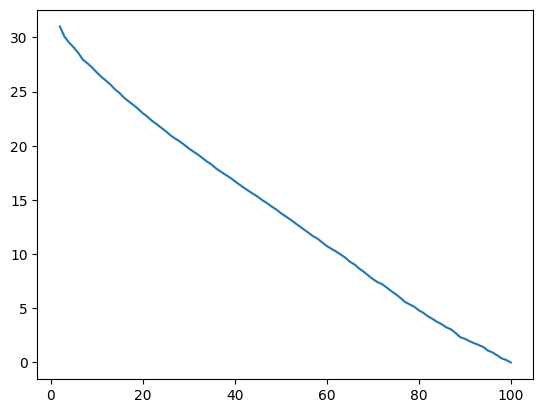

In [32]:
# Заполнение матрицы
N = 100
fullness = 40 * N
A = np.zeros(shape=(N, N))
random.seed(42)
pos = [[random.randint(0, N - 1), random.randint(0, N - 1)] for i in range(fullness)]
for k in pos:
    A[k[0], k[1]] = np.random.rand()

# Аппроксимация через PQR с разными рангами
ranks, errors = [], []
for r in range(1, N):
    piv, Q, R, rank = qr_pivoting(A, error = 0, rank = r)
    ranks += [int(rank)]
    errors += [float(np.linalg.norm(A[piv].T - Q.T @ R.T, ord='fro'))]

plt.plot(ranks, errors)
plt.show()

In [33]:
def maxvol(A, I, J, mode='column'):
    C = A[:, J] if mode == 'column' else A[I, :]
    B = A[I][:, J]
    C_Binv = C @ np.linalg.inv(B) if mode == 'column' else np.linalg.inv(B) @ C
    while True:
        pos = np.argmax(abs(C_Binv))
        i, j = pos // C_Binv.shape[1], pos % C_Binv.shape[1]
        if abs(C_Binv[i, j]) < 1.01:
            break
        if mode == 'column':
            I[j] = int(i)
            C_Binv = C_Binv - C_Binv[:, j].reshape((C_Binv.shape[0], 1)) @ (C_Binv[i, :].reshape((1, C_Binv.shape[1])) - np.eye(1, C_Binv.shape[1], j)) / C_Binv[i, j]
        else:
            J[i] = int(j)
            C_Binv = C_Binv - (C_Binv[:, j].reshape((C_Binv.shape[0], 1)) - np.eye(C_Binv.shape[0], 1, -i)) @ C_Binv[i, :].reshape((1, C_Binv.shape[1])) / C_Binv[i, j]
    return I, J

def maxvol_approx(A, I, J, steps = 4):
    dets = []
    for i in range(steps // 2):
        dets += [abs(float(np.linalg.det(A[I][:, J])))]
        I, J = maxvol(A, I, J, mode = 'column')
        dets += [float(np.linalg.det(A[I][:, J]))]
        I, J = maxvol(A, I, J, mode = 'row')
    if steps % 2 == 1:
        dets += [abs(float(np.linalg.det(A[I][:, J])))]
        I, J = maxvol(A, I, J, mode='column')
    dets += [abs(float(np.linalg.det(A[I][:, J])))]
    return I, J, dets

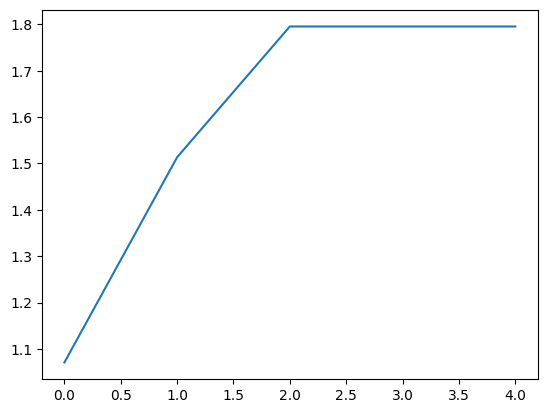

In [34]:
# Нахождение невырожденной подматрицы
P, L, U = scipy.linalg.lu(A)
U_rank = sum(abs(np.diag(U)) > 10**-10)
r = min(4, U_rank - 2)
I, J = [0] * r, [0] * r
l = 0
for k in range(len(np.diag(U))):
    if k < 2:
        continue
    if abs(U[k, k]) > 10**-10:
        J[l] = k
        for m, p in enumerate(P):
            if p[k] == 1:
                I[l] = m
        l += 1
        if l >= r:
            break

steps_num = 5
I, J, dets = maxvol_approx(A, I, J, steps_num - 1) # Запуск алгоритма аппроксимации
plt.plot([i for i in range(steps_num)], dets)
plt.show()

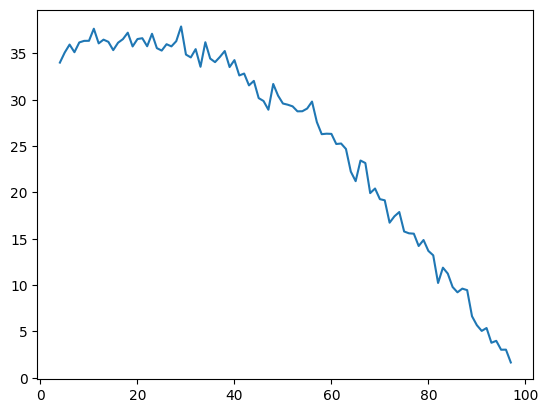

In [35]:
# Нахождение точности аппроксимации maxvol алгоритма в зависимости от ранга
P, L, U = scipy.linalg.lu(A)
U_rank = sum(abs(np.diag(U)) > 10**-10)
R = U_rank - 2
errors = []
for r in range(4, R):
  I, J = [0] * r, [0] * r
  l = 0
  for k in range(len(np.diag(U))):
      if k < 2:
          continue
      if abs(U[k, k]) > 10**-10:
          J[l] = k
          for m, p in enumerate(P):
              if p[k] == 1:
                  I[l] = m
          l += 1
          if l >= r:
              break

  steps_num = 10
  I, J, dets = maxvol_approx(A, I, J, steps_num - 1) # Запуск алгоритма аппроксимации
  errors += [np.linalg.norm(A - A[:, J] @ np.linalg.inv(A[I][:, J]) @ A[I, :])]
plt.plot([r for r in range(4, R)], errors)
plt.show()